In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Benchmarking across dataset subsets

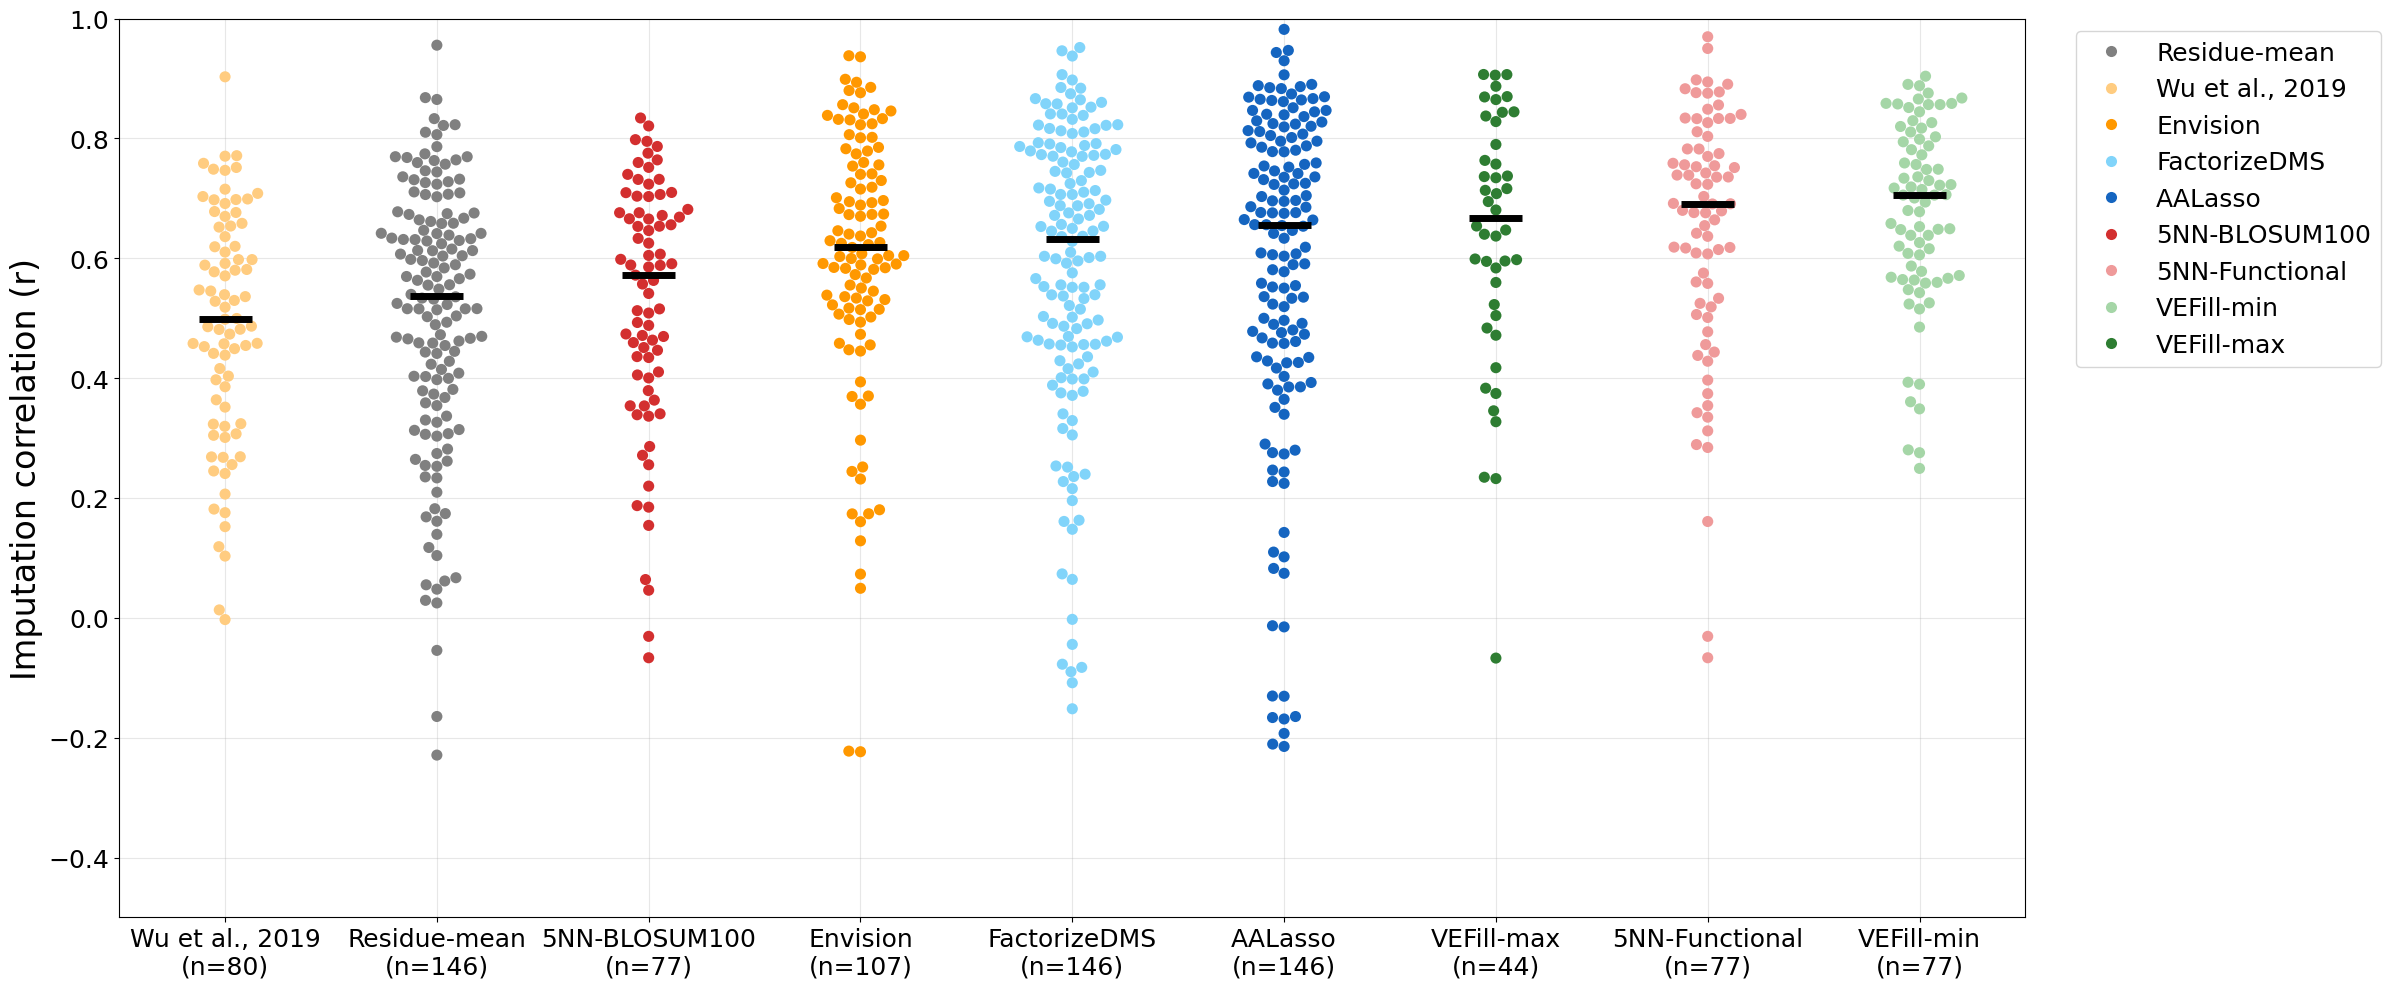

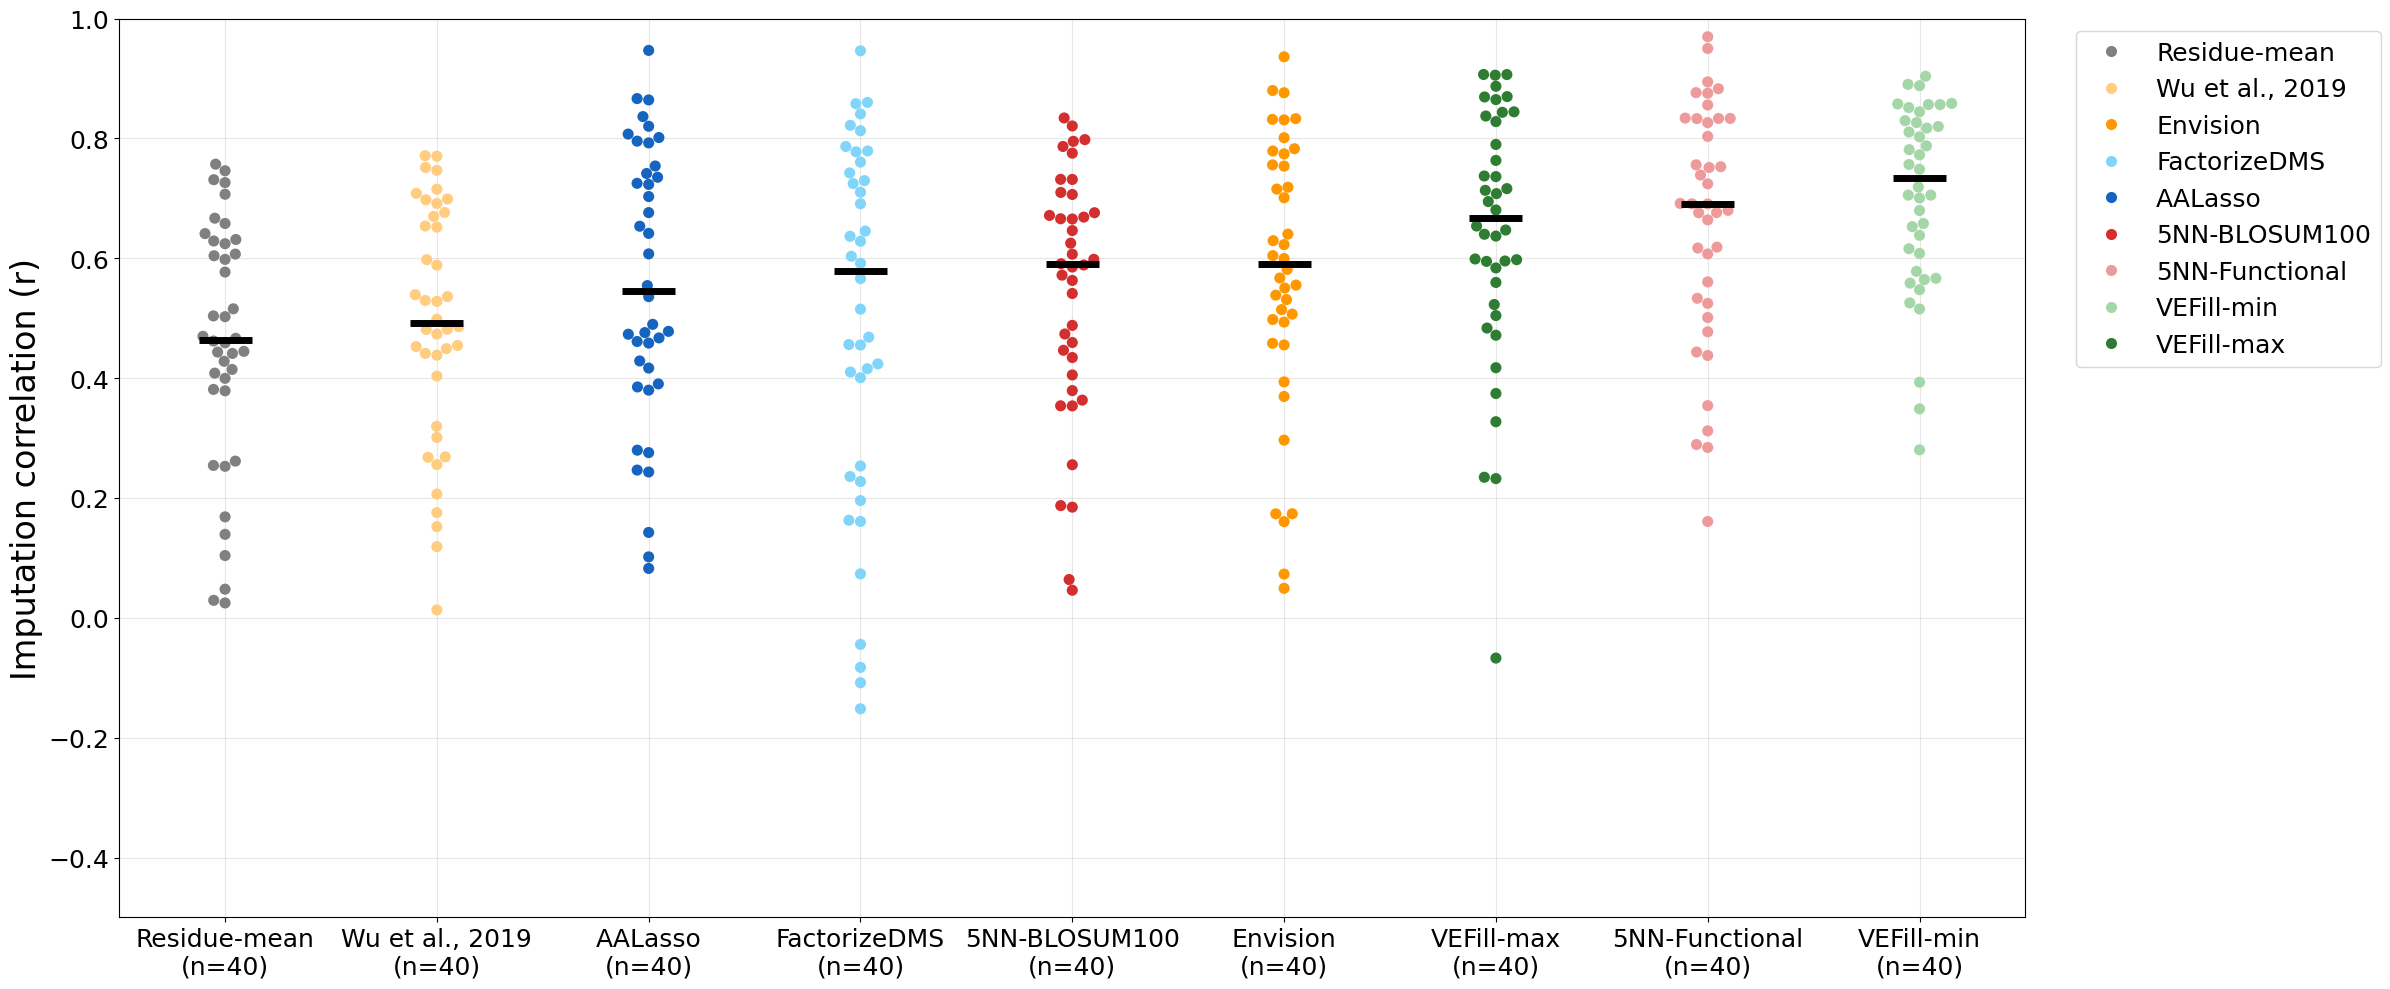

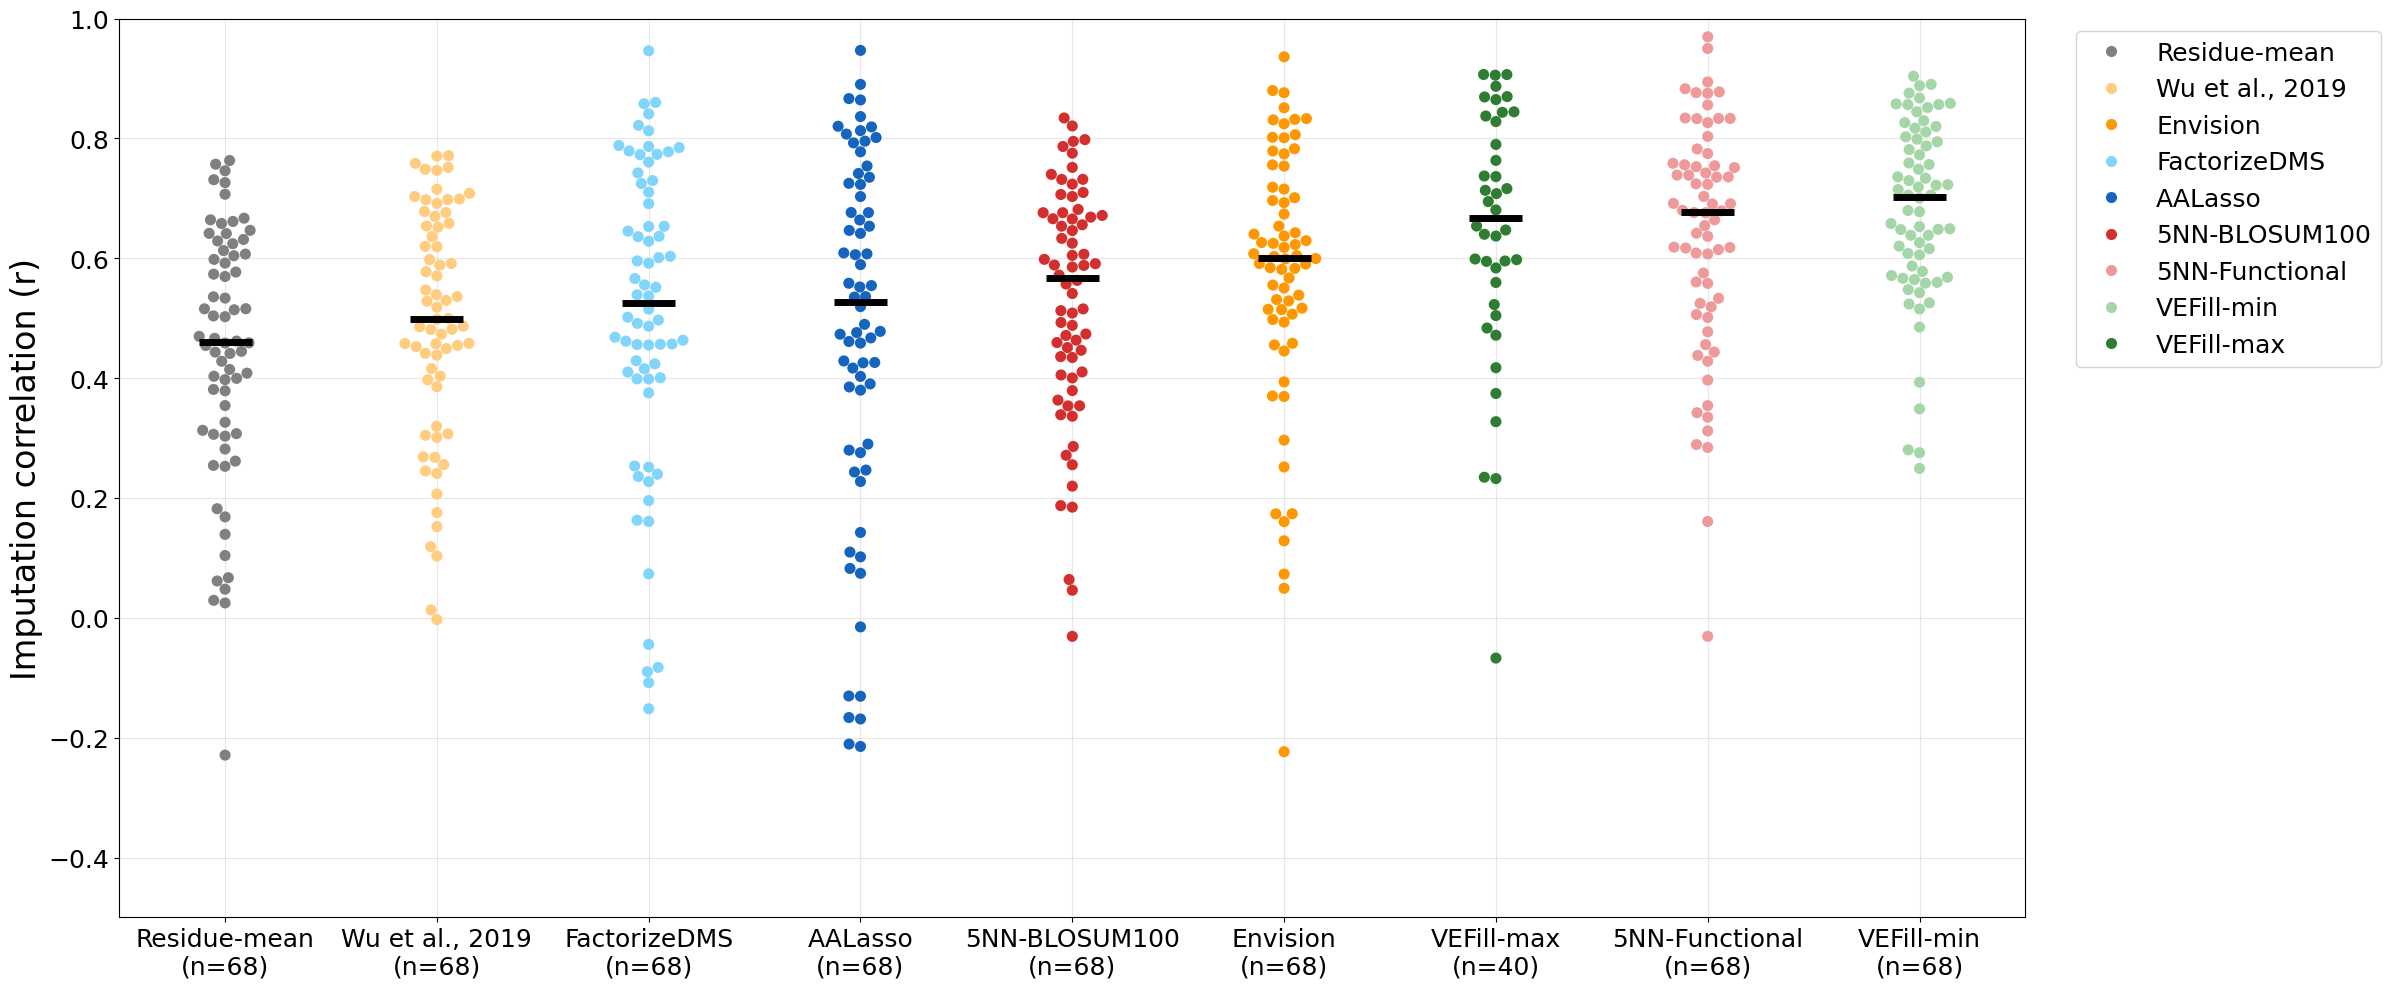

In [ ]:
# ----------------------------------------------------------
# Benchmarking across dataset subsets
# ----------------------------------------------------------
# Performance is evaluated per DMS dataset using Pearson r,
# and summarized across methods for three benchmarking regimes.

# ----------------------------------------------------------
# Load benchmarking results
# ----------------------------------------------------------
bench146_perf = pd.read_csv("data/performance_146.csv", index_col=0)
bench40_perf  = pd.read_csv("data/performance_40.csv", index_col=0)
bench68_perf  = pd.read_csv("data/performance_68.csv", index_col=0)

datasets = [
    ("All datasets", bench146_perf),
    ("40 datasets", bench40_perf),
    ("68 datasets", bench68_perf),
]

# ----------------------------------------------------------
# Final display labels for each method
# ----------------------------------------------------------
# Keys must match column names in performance tables
pretty_labels = {
    "row-mean_pears":        "Residue-mean",
    "wu2019_pears":          "Wu et al., 2019",
    "fdms_pears":            "FactorizeDMS",
    "lasso_pears":           "AALasso",
    "envision_pears":        "Envision",
    "vefill-max_pears":      "VEFill-max",
    "vefill-min_pears":      "VEFill-min",
    "5nn-blosum100_pears":   "5NN-BLOSUM100",
    "5nn-functional_pears":  "5NN-Functional",
}

# ----------------------------------------------------------
# Fixed color mapping (consistent across all figures)
# ----------------------------------------------------------
method_color_map = {
    "Residue-mean":   "#808080",
    "Wu et al., 2019":"#ffcc80",
    "Envision":       "#ff9800",
    "FactorizeDMS":   "#81d4fa",
    "AALasso":        "#1565c0",
    "VEFill-max":     "#2e7d32",
    "VEFill-min":     "#a5d6a7",
    "5NN-BLOSUM100":  "#d32f2f",
    "5NN-Functional": "#ef9a9a",
}

# ----------------------------------------------------------
# Main benchmarking loop
# ----------------------------------------------------------
for title, df in datasets:

    # Expected performance columns (subset may vary by benchmark)
    cols = [
        "row-mean_pears",
        "wu2019_pears",
        "envision_pears",
        "fdms_pears",
        "lasso_pears",
        "5nn-blosum100_pears",
        "5nn-functional_pears",
        "vefill-min_pears",
        "vefill-max_pears",
    ]
    cols = [c for c in cols if c in df.columns]

    # Aggregate per DMS dataset (median across repeats)
    work_data = (
        df.groupby("dms_id", as_index=False)
          .median(numeric_only=True)[cols + ["dms_id"]]
    )

    # Convert to long format
    work_data = work_data.melt(
        id_vars="dms_id",
        value_vars=cols,
        var_name="MethodRaw",
        value_name="r",
    )

    # Map to human-readable method names
    work_data["Method"] = work_data["MethodRaw"].map(pretty_labels)

    if work_data["Method"].isna().any():
        missing = work_data.loc[work_data["Method"].isna(), "MethodRaw"].unique()
        raise ValueError(f"Missing labels for methods: {missing}")

    # Add "(n=...)" counts to xticklabels
    xtick_labels = {}

    for raw_method, pretty in pretty_labels.items():
        if raw_method in work_data['MethodRaw'].unique():
            # Count only non-null correlations for that method
            n = (
                work_data.loc[
                    (work_data["MethodRaw"] == raw_method) &
                    (work_data["ρ"].notna())
                ]
                ["dms_id"]
                .nunique()
            )
            xtick_labels[pretty] = f"{pretty}\n(n={n})"

    work_data['MethodLabel'] = work_data['Method'].map(xtick_labels)

    # Assign colors consistently per method
    palette = [method_color_map[m] for m in work_data['Method'].unique()]
    
    # ----------------------------------------------------------
    # Sort swarms by median performance (high → low)
    # ----------------------------------------------------------
    median_order = (
        work_data.groupby("Method")["r"]
        .median()
        .sort_values()
        .index
        .tolist()
    )
    
    # ----------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(24, 10))

    sns.swarmplot(
        data=work_data,
        x="Method",
        y="r",
        hue='Method',
        palette=method_color_map,
        size=8,
        zorder=2,
        order=median_order,
        ax=ax
    )

    sns.boxplot(
        data=work_data,
        x="Method",
        y="r",
        showcaps=False,
        showbox=False,
        showfliers=False,
        whiskerprops={'visible': False},
        medianprops={'color': 'black', 'lw': 5},
        width=.25,
        zorder=5,
        order=median_order,
        ax=ax
    )

    # Formatting
    ax.set_xlabel("")
    ax.set_ylabel("Imputation correlation (r)", fontsize=24)
    plt.ylim([-0.5, 1])

    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)

    plt.grid(alpha=0.3)

    # Put legend outside
    ax.legend(fontsize=18, title_fontsize=20, bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()

    fname = title.lower().replace(" ", "_")
    outdir = "../figures"
    outfile = f"{outdir}/benchmark_swarm_{fname}.jpg"

    plt.savefig(outfile, bbox_inches="tight", dpi=300)
    plt.show()


## Model performance on different training data proportion

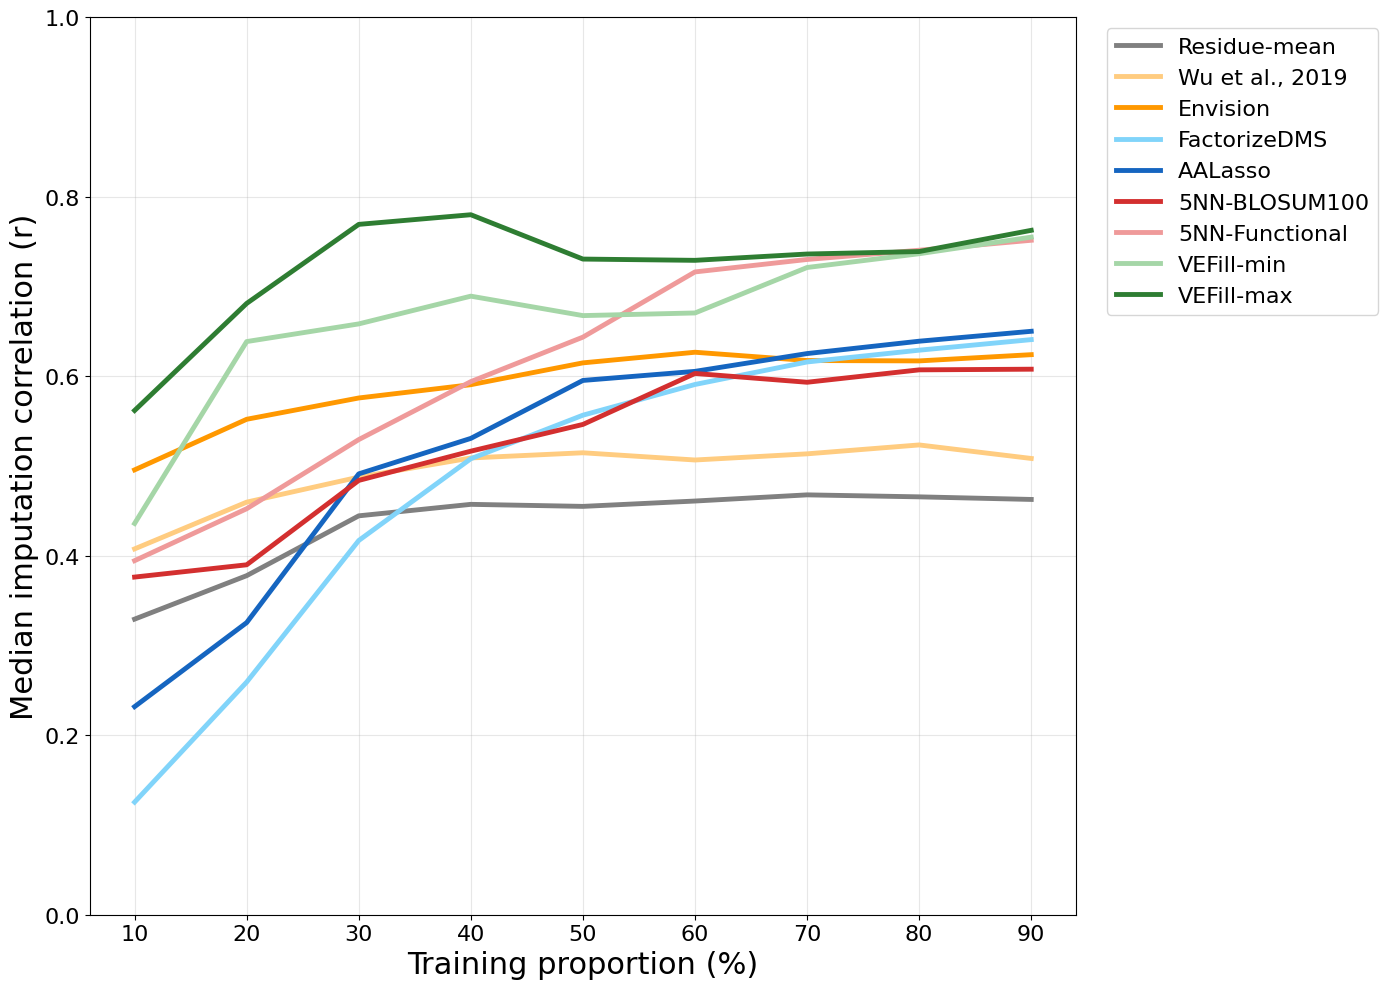

In [ ]:
# ----------------------------------------------------------
# Model performance as a function of training data availability
# ----------------------------------------------------------
# Performance is evaluated on 28 high-quality DMS datasets
# under increasing subsampling of the training data.

# -----------------------------------------------------
# LOAD DATA
# -----------------------------------------------------
df = pd.read_csv("data/performance_28.csv")

# -----------------------------------------------------
# TRAINING RATIO (% of data used for training)
# -----------------------------------------------------
df["train_ratio_vs_full"] = df["completeness"].astype(float).round(2)
df.loc[df["train_ratio_vs_full"] > 0.8, "train_ratio_vs_full"] = 0.9
df["train_ratio_vs_full"] *= 100

# -----------------------------------------------------
# METHOD LABELS (MUST match swarm plot)
# -----------------------------------------------------
method_map = {
    "row-mean_pred":               "Residue-mean",
    "fdms_pred":                   "FactorizeDMS",
    "lasso_pred":                  "AALasso",
    "envision_pred":               "Envision",
    "wu2019_pred":                 "Wu et al., 2019",
    "vefill-min_pears_dyn_mean":   "VEFill-min",
    "vefill-max_pears_dyn_mean":   "VEFill-max",
    "5nn-blosum100_pears_any":     "5NN-BLOSUM100",
    "5nn-functional_pears_any":    "5NN-Functional",
}

value_vars = list(method_map.keys())

df_long = df.melt(
    id_vars=["dms_id", "repeat", "train_ratio_vs_full"],
    value_vars=value_vars,
    var_name="method",
    value_name="Pearson_r"
)

df_long["Method"] = df_long["method"].map(method_map)

# -----------------------------------------------------
# COLOR MAP (SAME AS SWARM PLOT)
# -----------------------------------------------------
COLOR_MAP = {
    "Residue-mean":        "#808080",   # grey
    "Wu et al., 2019":     "#ffcc80",   # light orange
    "Envision":            "#ff9800",   # orange
    "FactorizeDMS":        "#81d4fa",   # light blue
    "AALasso":             "#1565c0",   # blue
    "VEFill-max":          "#2e7d32",   # green
    "VEFill-min":          "#a5d6a7",   # light green
    "5NN-BLOSUM100":       "#d32f2f",   # red
    "5NN-Functional":      "#ef9a9a",   # light red
}

def get_color(method_name: str) -> str:
    return COLOR_MAP.get(method_name, "black")

# -----------------------------------------------------
# AGGREGATE (median over repeats per training ratio)
# -----------------------------------------------------
plot_df = (
    df_long
    .groupby(["train_ratio_vs_full", "Method"], as_index=False)
    .median(numeric_only=True)
)

# Drop methods that ended up all-NaN (just in case)
valid_methods = plot_df.groupby("Method")["Pearson_r"].apply(
    lambda x: x.notna().any()
)
plot_df = plot_df[plot_df["Method"].isin(valid_methods[valid_methods].index)]

# -----------------------------------------------------
# PLOT
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 10))

# Fixed plot order to match swarm style
method_order = [
    "Residue-mean",
    "Wu et al., 2019",
    "Envision",
    "FactorizeDMS",
    "AALasso",
    "5NN-BLOSUM100",
    "5NN-Functional",
    "VEFill-min",
    "VEFill-max"
]

for method in method_order:
    sub = plot_df[plot_df["Method"] == method]
    if sub.empty:
        continue  # skip if method not present

    ax.plot(
        sub["train_ratio_vs_full"],
        sub["Pearson_r"],
        label=method,
        linewidth=3.5,
        color=get_color(method),
    )

# -----------------------------------------------------
# STYLING
# -----------------------------------------------------
ax.grid(alpha=0.3)
ax.set_xlabel("Training proportion (%)", fontsize=22)
ax.set_ylabel("Median imputation correlation (r)", fontsize=22)
ax.set_ylim(0, 1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Legend to the right (like swarm)
ax.legend(
    fontsize=16,
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()

plt.savefig("../figures/Figure_SX.jpg", dpi=300)
plt.show()


### Minimal mutations per position required

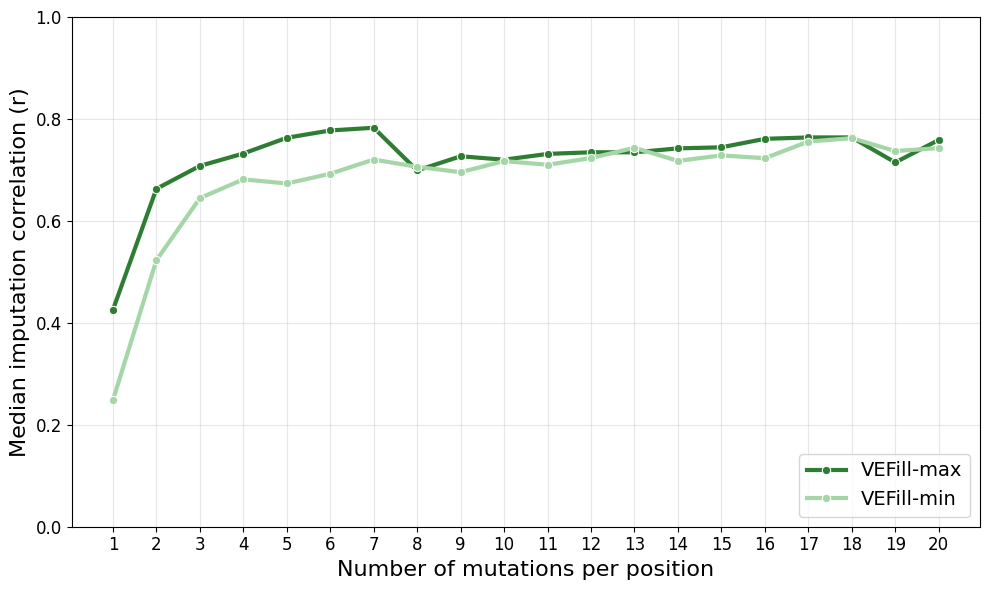

In [ ]:
# ------------------------------------------------------------
# Minimal number of mutations per position required for VEFill
# ------------------------------------------------------------
# Median performance is computed across genes as a function of
# the number of observed substitutions per residue position.

# ------------------------------------------------------------
# Load result table
# ------------------------------------------------------------
df = pd.read_csv("data/minimal_per_position.csv")
# expected columns:
# gene_id, N_mutations_per_position, vefill-max_pears, vefill-min_pears

# Ensure numeric
df["N_mutations_per_position"] = df["N_mutations_per_position"].astype(int)
df["vefill-max_pears"] = pd.to_numeric(df["vefill-max_pears"], errors="coerce")
df["vefill-min_pears"] = pd.to_numeric(df["vefill-min_pears"], errors="coerce")

# ------------------------------------------------------------
# Compute median performance across genes for each N
# ------------------------------------------------------------
median_df = (
    df.groupby("N_mutations_per_position")[["vefill-max_pears", "vefill-min_pears"]]
      .median()
      .reset_index()
)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))

# VEFill-max → dark green
sns.lineplot(
    data=median_df,
    x="N_mutations_per_position",
    y="vefill-max_pears",
    marker="o",
    linewidth=3,
    color="#2e7d32",
    label="VEFill-max"
)

# VEFill-min → light green
sns.lineplot(
    data=median_df,
    x="N_mutations_per_position",
    y="vefill-min_pears",
    marker="o",
    linewidth=3,
    color="#a5d6a7",
    label="VEFill-min"
)

plt.grid(alpha=0.3)
plt.xlabel("Number of mutations per position", fontsize=16)
plt.ylabel("Median imputation correlation (r)", fontsize=16)
plt.xticks(median_df["N_mutations_per_position"], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

#plt.title("Predictive power vs. number of mutations per position", fontsize=18)

plt.legend(fontsize=14, loc="lower right")

plt.tight_layout()

plt.savefig("../figures/Appendix_Figure_S18.jpg", dpi=300)
plt.show()
